# EDA 
**How to use**
1. Open this file in Jupyter / JupyterLab / Colab.  
2. Run cells *top to bottom* (Kernel: Python 3.10+ recommended).  
3. When running data fetch cells you'll need internet for `yfinance`; if offline, use the backup CSV path provided in the CONFIG cell.
4. Presentation tip: For each plot, read the short interpretation prompts provided below the plot cells.


In [1]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
import plotly.graph_objects as go
import plotly.express as px


# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

# display inline (Jupyter)
%matplotlib inline

print("Packages imported. Matplotlib inline ready.")

Packages imported. Matplotlib inline ready.


## 2) Configuration
Edit `CONFIG` below for tickers, date range, and file paths. For presentations it's convenient to keep defaults,
but you can change tickers or dates interactively.


In [2]:
# 2) Configuration (edit if needed)
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}
CONFIG

{'tickers': ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA'],
 'start_date': '2022-01-01',
 'end_date': '2025-01-01',
 'backup_path': 'data/backup_stocks.csv',
 'output_long': 'data/cleaned_stock_data_long.csv',
 'output_wide': 'data/cleaned_stock_data_wide.csv'}

## 3) Data Acquisition
This cell defines `fetch_stock_data()` which uses `yfinance` and falls back to a CSV if `yfinance` fails.
Run the cell to fetch data (or, if offline, ensure backup CSV exists).

In [3]:
def fetch_stock_data(tickers, start, end, backup_path):
    """Fetch historical stock data from yfinance (multi-ticker) with CSV fallback."""
    try:
        # Validate input
        if not tickers:
            raise ValueError("No tickers provided")

        # Attempt to fetch from yfinance
        data = yf.download(
            tickers,
            start=start,
            end=end,
            group_by="ticker",
            auto_adjust=True,
            progress=False
        )

        if data.empty:
            raise ValueError("Empty response from yfinance")

        print(f"Data fetched for {len(tickers) if isinstance(tickers, list) else 1} "
              f"ticker(s): {start} → {end}")
        return data

    except Exception as e:
        # Fallback to backup CSV if API call fails
        print(f"yfinance failed: {e}. Loading backup CSV: {backup_path}")
        return pd.read_csv(backup_path, parse_dates=['Date'])


# Example usage (uncomment to run in notebook)
raw_data = fetch_stock_data(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'], CONFIG['backup_path'])
raw_data.head()

Data fetched for 5 ticker(s): 2022-01-01 → 2025-01-01


Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.061378  144.851931  142.728576  143.998322  28646000   
2022-01-04  144.400080  145.481626  142.732095  143.410416  28400000   
2022-01-05  143.430724  143.509678  136.744843  136.831238  54618000   
2022-01-06  136.060093  138.981442  135.623104  136.803955  37348000   
2022-01-07  137.199210  137.500143  134.836508  136.078445  29760000   

Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400   
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300   
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800   
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600   
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700   

Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086189  327.655077  319.686659  324.504547  28865100   
2022-01-04  324.582127  324.940827  316.138715  318.940277  32674300   
2022-01-05  315.886673  316.090267  306.309087  306.696838  40054300   
2022-01-06  303.565739  308.945893  301.956541  304.273407  39646100   
2022-01-07  304.535086  306.813167  300.599349  304.428467  32720000   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  174.345039  179.296076  174.227395  178.443115  104487900   
2022-01-04  179.050994  179.354917  175.609770  176.178406   99310400   
2022-01-05  176.090189  176.639212  171.217584  171.492096   94537600   
2022-01-06  169.315582  171.864636  168.276357  168.629303   96904000   
2022-01-07  169.501851  170.727354  167.678301  168.795959   86709100   

Ticker             JPM                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2022-01-03  143.926634  146.429548  143.611513  145.583237  13120900  
2022-01-04  147.933087  151.777496  147.861059  151.102249  20195800  
2022-01-05  151.998939  152.488025  148.294509  148.339798  17539400  
2022-01-06  151.174730  151.591356  148.421315  149.915771  14047500  
2022-01-07  150.051647  151.736298  149.499154  151.401184  13913300

## 4) Cleaning functions
Contains `clean_stock_data()` and `clean_all_tickers()` — robust cleaning, normalize dates, handle missing values, enforce numeric types.


In [4]:
# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure required columns are present
        - Normalize and sort by date
        - Handle missing values (drop if >50%, else forward/backward fill)
        - Drop duplicates and enforce numeric dtypes
        - Validate constraints (non-negative prices, volumes and valid dates)
    """
    df = df.copy().reset_index()
    df["Ticker"] = ticker

    # Validate inputs and check required columns
    required_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' for {ticker}")

    if df.empty:
        raise ValueError(f"No data available for {ticker}")

    # Normalize and sort dates
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    missing_pct = df[core_cols].isnull().mean(axis=1)
    df = df[missing_pct < 0.5] # Drop rows with excessive missing values

    # Fill remaining missing values using forward/backward fill
    df = df.ffill().bfill() 

    # Drop duplicate dates
    df.drop_duplicates(subset=["Date"], inplace=True)

    # Ensure numeric types
    for col in core_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Validation: no negative values
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"Negative prices detected for {ticker}")
    if (df["Volume"] < 0).any():
        raise ValueError(f"Negative volumes detected for {ticker}")

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)

    return df


def clean_all_tickers(raw_data: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    """
    Clean stock data for multiple tickers and combine into a single DataFrame.
    """
    cleaned_list = []

    for t in tickers:
        try:
            temp = raw_data[t].reset_index()
            cleaned = clean_stock_data(temp, t)
            cleaned_list.append(cleaned)
            print(f"{t} cleaned successfully ({len(cleaned)} rows).")
        except Exception as e:
            print(f"Error processing {t}: {e}")

    combined = pd.concat(cleaned_list, ignore_index=True)

    # Drop extra 'index' column if present
    if "index" in combined.columns:
        combined.drop(columns=["index"], inplace=True)

    return combined


# Example usage (uncomment to run after fetching data)
cleaned_data = clean_all_tickers(raw_data, CONFIG["tickers"])
print(f"Final cleaned dataset shape: {cleaned_data.shape}")
cleaned_data.head()


AAPL cleaned successfully (753 rows).
MSFT cleaned successfully (753 rows).
GOOGL cleaned successfully (753 rows).
JPM cleaned successfully (753 rows).
TSLA cleaned successfully (753 rows).
Final cleaned dataset shape: (3765, 7)


Price,Date,Open,High,Low,Close,Volume,Ticker
0,2022-01-03,174.345039,179.296076,174.227395,178.443115,104487900,AAPL
1,2022-01-04,179.050994,179.354917,175.609770,176.178406,99310400,AAPL
2,2022-01-05,176.090189,176.639212,171.217584,171.492096,94537600,AAPL
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL
4,2022-01-07,169.501851,170.727354,167.678301,168.795959,86709100,AAPL


## 5) Trading day alignment & Outlier detection
Align data with NYSE trading calendar and detect outliers using Z-score and IQR.


In [5]:
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


# Example usage (after cleaning):
cleaned_data = align_with_trading_days(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])


Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


In [6]:
def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("Outlier detection completed (Z-score & IQR).")
    return df

# Example usage (after cleaning):
cleaned_data = detect_outliers(cleaned_data)
cleaned_data.head()

Outlier detection completed (Z-score & IQR).


Price,Date,Open,High,Low,Close,Volume,Ticker,Daily_Return,Z_Score,Outlier_Z,Outlier_IQR
0,2022-01-03,174.345039,179.296076,174.227395,178.443115,104487900,AAPL,NaN,NaN,False,False
1,2022-01-04,179.050994,179.354917,175.609770,176.178406,99310400,AAPL,-0.012691,-0.778768,False,False
2,2022-01-05,176.090189,176.639212,171.217584,171.492096,94537600,AAPL,-0.026600,-1.594220,False,False
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL,-0.016693,-1.013404,False,False
4,2022-01-07,169.501851,170.727354,167.678301,168.795959,86709100,AAPL,0.000988,0.023286,False,False


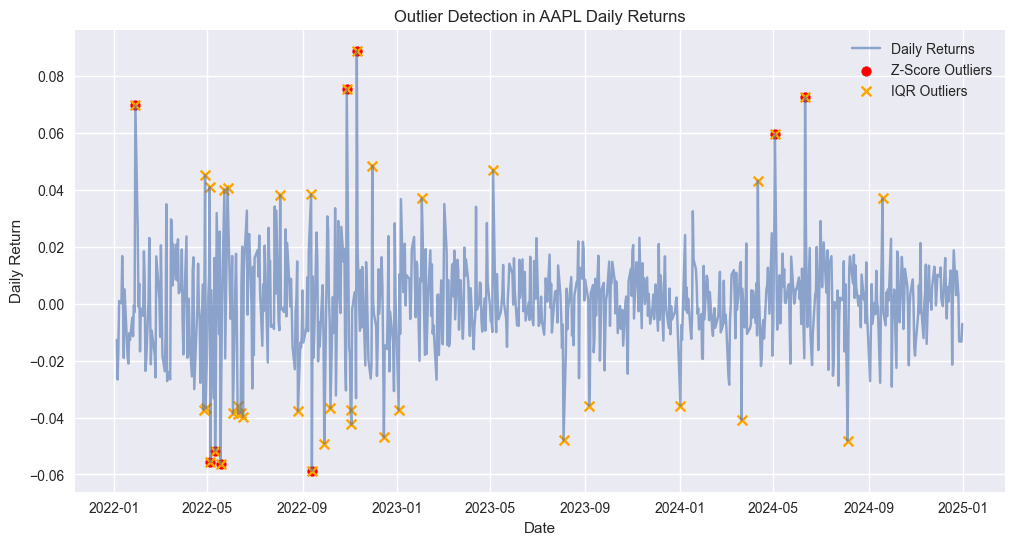

In [7]:
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()

# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

### Outlier Detection in AAPL Daily Returns

The graph above visualizes Apple's daily returns from 2022 to 2024, along with detected outliers using two statistical methods — **Z-Score** (red dots) and **IQR** (orange crosses). The blue line represents the stock’s day-to-day percentage change in price.

#### Observations
- The daily returns fluctuate around zero, indicating that Apple's stock generally maintains a balanced return distribution over time without a clear upward or downward drift.
- Several large spikes and drops can be seen around **mid-2022** and **mid-2024**, suggesting periods of increased volatility possibly driven by market events or company-specific news.
- Both Z-Score and IQR methods detect overlapping outliers, showing consistency in identifying extreme price movements.  
  - **Z-Score outliers** represent days where returns deviate significantly from the mean.  
  - **IQR outliers** capture moderately extreme deviations outside the interquartile range.

#### Insights
- The presence of multiple outliers highlights **days with unusually high volatility**, which may be important for understanding market reactions to key events.
- Positive and negative outliers indicate that **large price swings occur in both directions**, reflecting the market’s response to changing investor sentiment.
- Periods with more frequent outliers could correspond to **higher uncertainty or market shocks**.

## 6) Data quality report & validation
A short per-ticker report and automated validation tests.


In [8]:
# 6. Data Quality & Validation

def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicate dates
        - Coverage of expected NYSE trading days
    """
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    report = []
    nyse = mcal.get_calendar('NYSE')  # NYSE trading calendar

    # Group by ticker and calculate metrics
    for ticker, group in df.groupby('Ticker'):
        total_rows = len(group)
        
        # Missing values %
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        
        # Duplicate date count
        duplicates = group.duplicated(subset=['Date']).sum()
        
        # Date range
        min_date, max_date = group['Date'].min(), group['Date'].max()
        
        # Trading days coverage
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan
        
        # Append metrics to report
        report.append({
            'Ticker': ticker,
            'Rows': total_rows,
            'Date Range': f'{min_date.date()} → {max_date.date()}',
            'Missing %': f'{missing_pct:.2f}%',
            'Duplicates': duplicates,
            'Coverage %': f'{coverage_pct:.2f}%'
        })
    
    return pd.DataFrame(report)

# Example usage (after cleaning and outlier detection)
report = data_quality_report(cleaned_data)
print("Data Quality Report")
display(report)  # Display summary table

Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%


In [9]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame, start_date: str, end_date: str):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group['Date'].min() >= pd.to_datetime(start_date), f'Start date invalid for {ticker}'
        assert group['Date'].max() <= pd.to_datetime(end_date), f'End date invalid for {ticker}'

    print("Preprocessing validations passed!")


# Run validation checks
validate_preprocessing(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])

Preprocessing validations passed!


## 7) Pivot to wide format & basic statistics
Create a pivot table of Close prices and compute mean/volatility/skew/kurtosis/sharpe.


In [10]:
def pivot_wide(df):
    pivot = df.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill()
    return pivot

def compute_stats(pivot):
    daily_returns = pivot.pct_change().dropna()
    stats_df = pd.DataFrame({
        'Ticker': daily_returns.columns,
        'Mean Return': daily_returns.mean(),
        'Volatility (Std)': daily_returns.std(),
        'Min Return': daily_returns.min(),
        'Max Return': daily_returns.max(),
        'Skewness': daily_returns.skew(),
        'Kurtosis': daily_returns.kurtosis(),
        'Sharpe (approx)': daily_returns.mean()/daily_returns.std()
    }).reset_index(drop=True)
    return stats_df

# Example usage:
pivot = pivot_wide(cleaned_data)
stats_df = compute_stats(pivot)
stats_df

,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe (approx)
0,AAPL,0.000591,0.017067,-0.058679,0.088975,0.213376,2.514826,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102244,0.013494,2.727523,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398059,5.741116,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009360,1.955805,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


## 8) Visualizations (presentation-ready)
Plot price series, SMAs, rolling volatility, correlation heatmap, boxplots, and outlier visualisations.
Each plot cell includes a short presenter note you can read aloud.


In [11]:
# Pivot cleaned_data to wide format
pivot = cleaned_data.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill().reset_index()

# Calculate SMAs for AAPL (example)
pivot['SMA_20'] = pivot['AAPL'].rolling(20).mean()
pivot['SMA_50'] = pivot['AAPL'].rolling(50).mean()

In [12]:
import plotly.graph_objects as go
import numpy as np

def plot_price_sma_eda(dates, prices, smas, ticker="AAPL", title="Price with SMA Overlay"):
    fig = go.Figure()

    # === Closing Price Line ===
    fig.add_trace(go.Scatter(
        x=dates,
        y=prices,
        mode='lines',
        name=f'{ticker} Close',
        line=dict(color='green', width=2),
        hovertemplate='Date: %{x}<br>Close: %{y:.2f}<extra></extra>'
    ))

    # === SMA Lines ===
    colors = ['blue', 'orange', 'purple', 'red']  # distinct colors for multiple SMAs
    for i, sma in enumerate(smas):
        fig.add_trace(go.Scatter(
            x=dates,
            y=sma,
            mode='lines',
            name=sma.name,
            line=dict(width=2, dash='dash', color=colors[i % len(colors)]),
            hovertemplate=f'Date: %{{x}}<br>{sma.name}: %{{y:.2f}}<extra></extra>'
        ))

    # === Highlight SMA Crossovers ===
    if len(smas) >= 2:
        diff = smas[0] - smas[1]
        crossover_indices = np.where(np.sign(diff) != np.sign(diff.shift(1)))[0]
        fig.add_trace(go.Scatter(
            x=dates[crossover_indices],
            y=prices.iloc[crossover_indices],
            mode='markers',
            name='Crossover',
            marker=dict(size=8, color='red', symbol='x'),
            hovertemplate='Crossover: %{x}<br>Price: %{y:.2f}<extra></extra>'
        ))

    # === Layout for EDA Readability ===
    fig.update_layout(
        title=dict(
            text=f"{ticker} {title}<br><sup>{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}</sup>",
            x=0.5,
            font=dict(size=22)
        ),
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        margin=dict(l=40, r=40, t=100, b=40),
        height=600
    )

    fig.show()


# === Example usage ===
sma_list = [pivot['SMA_20'], pivot['SMA_50']]
for s in sma_list:
    s.name = s.name  # ensure each series has a name

plot_price_sma_eda(pivot['Date'], pivot['AAPL'], sma_list, ticker="AAPL", title="Price with 20 & 50 SMA")


### AAPL Price and Moving Average Crossovers (2022–2024) ####
The graph above displays Apple's closing price from January 2022 to December 2024, along with its 20-day (blue dashed) and 50-day (orange dashed) simple moving averages (SMA). Points marked with red crosses indicate crossover events—moments where the 20-day SMA crosses above or below the 50-day SMA.

#### Observations
- Apple's price experienced notable fluctuations, beginning with a downtrend in the first half of 2022, followed by a sustained recovery and significant price surge into late 2024.
- Crossover events (red markers) are clustered during volatile periods, such as mid-2022's decline, the bottoming out and initial rebound in early 2023, and the strong bullish trend in late 2024.

#### Insights
- Crossover signals can be useful for trend identification, as frequent crossovers may signal uncertainty, while prolonged separation of SMAs (as seen during the strong rally in 2024) can point to a robust trend.
- Clusters of crossovers typically correspond to choppy market periods, suggesting a lack of clear direction or increased volatility.
- The pronounced price rally in late 2024, accompanied by a sustained gap between the 20-day and 50-day SMAs and marked by crossovers, highlights a period of strong upward momentum—potentially driven by significant market or company news.

In [25]:
def highlight_streaks_notebook(df, price_cols, date_col='Date', title="Price Streaks"):
    fig = go.Figure()

    for price_col in price_cols:
        change = df[price_col].diff().fillna(0)
        for i in range(1, len(df)):
            color = 'green' if change.iloc[i] > 0 else ('red' if change.iloc[i] < 0 else 'blue')
            fig.add_trace(go.Scatter(
                x=df[date_col].iloc[i-1:i+1],
                y=df[price_col].iloc[i-1:i+1],
                mode='lines',
                line=dict(color=color, width=3),
                showlegend=False
            ))

        # Add label for each stock at the last data point
        fig.add_annotation(
            x=df[date_col].iloc[-1],
            y=df[price_col].iloc[-1],
            text=price_col,
            showarrow=False,
            font=dict(size=14, color='black', family='Arial', weight='bold'),
            xanchor='left',
            yanchor='middle',
            bgcolor='rgba(255,255,255,0.7)'
        )

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=22)),
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white',
        width=1200,
        height=600
    )

    fig.show()


# Example usage
stocks_to_plot = ['AAPL', 'MSFT', 'GOOGL']
highlight_streaks_notebook(pivot, stocks_to_plot, date_col='Date', title="Stock Price Streaks")



#### Stock Price Streaks for MSFT, AAPL, GOOGL (2022–2024) ####
The chart above displays the price movements of Microsoft (MSFT, top line), Apple (AAPL, middle line), and Google (GOOGL, bottom line) from 2022 to 2024, segmented by streaks of consecutive up days (green) and down days (red). These streaks visually represent periods of continuous gains or losses for each stock.

### Observations
- Microsoft (MSFT), at the top, exhibited longer green streaks in 2023 and mid-2024, reflecting strong upward momentum and a robust recovery after early 2022 declines.
- Apple (AAPL), the middle line, shows shorter alternating streaks, particularly in 2022 and early 2023, indicating more choppy price action and frequent reversals compared to MSFT.
- Google (GOOGL), the bottom line, experienced significant red streaks in early 2022 followed by clusters of green stretches, especially persisting into the latter half of 2024, suggesting a remarkable turnaround.

### Insights
- Persistent green streaks in MSFT often coincide with market-wide bullish phases or strong company performance, while clusters of red streaks—especially for GOOGL in early 2022—suggest periods of sector-specific or broader negative sentiment.
- Comparatively, AAPL demonstrated the highest frequency of switches between gain and loss streaks, highlighting its sensitivity to both macroeconomic and company-level factors during this window.

In [14]:
def annotate_profits_notebook(df, prices, sma, date_col='Date', title="Buy/Sell Signals"):
    buy_signals, sell_signals = [], []
    flag = -1
    for i in range(len(df)):
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(None)
                flag = 1
            else:
                buy_signals.append(None)
                sell_signals.append(None)
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:
                buy_signals.append(None)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(None)
                sell_signals.append(None)
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Price Line
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df[prices],
        mode='lines', name='Close Price',
        line=dict(color='blue', width=2)
    ))

    # SMA Line
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df[sma],
        mode='lines', name=sma,
        line=dict(color='orange', width=2, dash='dash')
    ))

    # Buy Signals (green dots)
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='circle', color='green', size=8, opacity=0.9),
        hovertemplate='Buy Signal<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    # Sell Signals (red dots)
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='circle', color='red', size=8, opacity=0.9),
        hovertemplate='Sell Signal<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=22)),
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white',
        width=1200,
        height=600,
        legend=dict(orientation='h', y=1.05, x=0.5, xanchor='center')
    )

    fig.show()


# Example usage
pivot['SMA_20'] = pivot['AAPL'].rolling(20).mean()
annotate_profits_notebook(
    pivot,
    prices='AAPL',
    sma='SMA_20',
    date_col='Date',
    title="AAPL Buy/Sell Signals (20 SMA)"
)


#### Buy/Sell Signal Chart for AAPL Using 20-Day SMA (2022–2025) ####
This chart shows Apple's (AAPL) closing prices from January 2022 to January 2025, highlighting strategic Buy and Sell signals based on a 20-day Simple Moving Average (SMA_20). The blue line tracks actual price movement, while the orange dashed line reflects the SMA trend. Green dots mark Buy signals and red dots show Sell signals across the time window.

### Observations
- Buy signals (green) consistently occur after downtrends, typically at local lows and during SMA crossovers
- Sell signals (red) appear at local highs and after rallies, denoting anticipated trend reversals as the price crosses below the SMA_20.
- Signals are more frequent in volatile periods, especially during pronounced price swings in 2022 and 2023. In trending markets, such as the strong rally in late 2024, signals are sparser, aligning with extended periods above or below the SMA.

### Insights
- Sustained uptrends (e.g., 2024) illustrate fewer signals and longer periods of holding, reducing trading frequency and potentially increasing gains.
- Reviewing Buy/Sell signals over market cycles helps investors refine timing and assess risk across changing market conditions, making the visual guide a valuable asset for systematic trading decisions.

In [15]:
def plot_annual_risk_return_notebook(df):
    # Drop 'Date' if it exists, otherwise just work with df
    data = df.copy()
    if "Date" in data.columns:
        data = data.drop(columns=["Date"])
    
    returns = data.pct_change().dropna()
    summary = pd.DataFrame({
        "Ticker": returns.columns,
        "Annual Return": returns.mean() * 252,
        "Annual Risk": returns.std() * (252 ** 0.5)
    })
    summary["Sharpe Ratio"] = summary["Annual Return"] / summary["Annual Risk"]

    # Now 'Ticker' exists, so text="Ticker" will work
    fig = px.scatter(
        summary, x="Annual Risk", y="Annual Return",
        text="Ticker", size="Sharpe Ratio", color="Ticker"
    )
    fig.update_traces(textposition="top center")
    fig.update_layout(
        title=dict(text="Annual Risk vs Return", x=0.5, font=dict(size=22)),
        width=900, height=600
    )
    fig.show()

# Call function
plot_annual_risk_return_notebook(pivot)


C:\Users\Cereb\AppData\Local\Temp\ipykernel_6520\2954977108.py:7: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



#### Annual Risk vs Return Bubble Chart Analysis ####
The bubble chart above depicts the annual risk (x-axis) versus annual return (y-axis) for a set of assets, including major stocks (TSLA, AAPL, MSFT, GOOGL, JPM), strategy indicators (SMA_20, SMA_50), and trade signals (Buy, Sell). Each bubble’s position reflects its risk-return profile, while size likely denotes an additional asset attribute such as trading volume or signal intensity.

### Observations
- Tesla (TSLA), located in the top-right corner, displays both the highest annual risk and highest annual return, marking it as the most volatile and potentially most lucrative asset on the chart. This reflects frequent large price movements and above-average reward potential.
- JPMorgan Chase (JPM), positioned among the stocks with moderate risk and top-tier annual return, indicates a favorable risk-adjusted performance during the observed period.

### Insights
- Assets with high risk and high return, like TSLA, may appeal to aggressive investors seeking explosive growth, but demand careful management due to large drawdowns.
- The proximity of AAPL, MSFT, and GOOGL in the middle risk-return zone illustrates balanced profiles, suitable for moderate risk tolerance.

In [16]:
# --- Highlight Price Streaks ---
def highlight_streaks(df, stock_cols, title="Stock Price Streaks"):
    fig = go.Figure()
    for col in stock_cols:
        changes = df[col].diff().fillna(0)
        for i in range(1, len(df)):
            color = 'green' if changes.iloc[i] > 0 else ('red' if changes.iloc[i] < 0 else 'blue')
            fig.add_trace(go.Scatter(x=df['Date'].iloc[i-1:i+1], y=df[col].iloc[i-1:i+1],
                                     mode='lines', line=dict(color=color, width=3),
                                     showlegend=i == len(df)-1, name=col if i == len(df)-1 else None))
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title="Price", template="plotly_white", width=900, height=500)
    fig.show()

# Example usage:
highlight_streaks(pivot.reset_index(), ['AAPL', 'MSFT'])


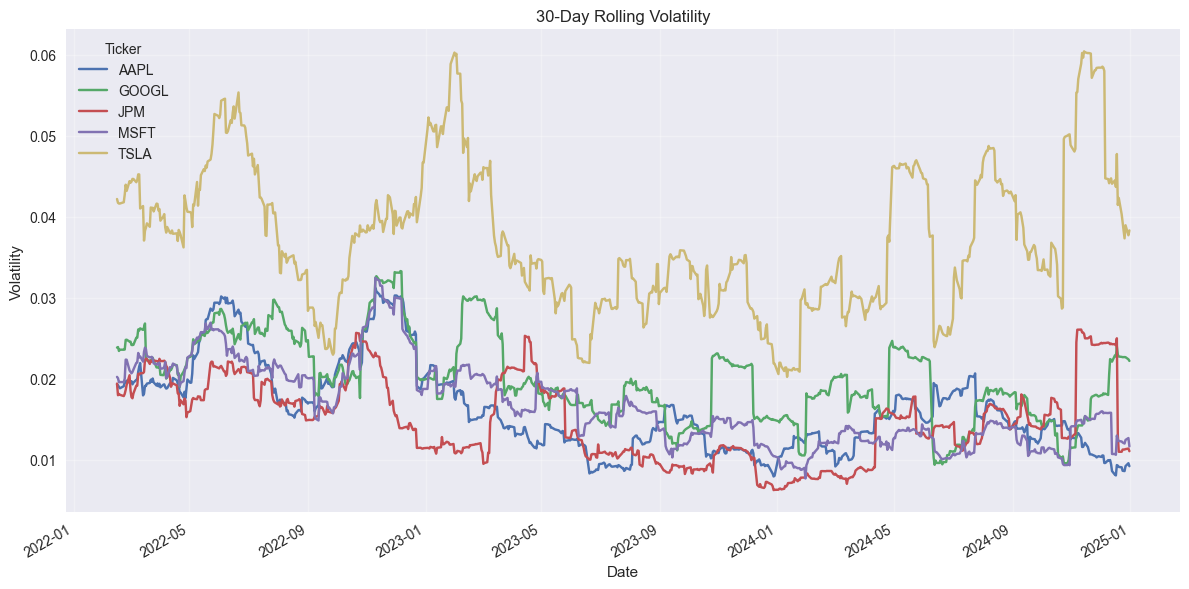

In [17]:
def plot_rolling_vol(df, window=30):
    """
    Plot rolling volatility for stock prices only.
    - Excludes non-price columns like SMA or technical indicators.
    - Shows Date properly on x-axis.
    """
    data = df.copy()

    # Ensure Date is set as index for proper plotting
    if 'Date' in data.columns:
        data = data.set_index('Date')

    # Select only stock price columns (exclude SMA, Buy/Sell, etc.)
    stock_cols = [col for col in data.columns if not col.startswith('SMA') and col not in ['Buy','Sell']]
    data = data[stock_cols]

    # Compute rolling volatility
    rolling_vol = data.pct_change().rolling(window=window).std()

    # Plot
    rolling_vol.plot(figsize=(12, 6), title=f"{window}-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend(title="Ticker")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_rolling_vol(pivot, window=30)

#### 30-Day Rolling Volatility for AAPL, GOOGL, JPM, MSFT, TSLA (2022–2025) ####
The chart, based on the provided code, would show the 30-day rolling volatility for Apple (AAPL), Google (GOOGL), JPMorgan Chase (JPM), Microsoft (MSFT), and Tesla (TSLA) with the x-axis spanning 2022 through 2025. Each line represents one ticker’s evolving risk profile.

### Observations
- Tesla (TSLA) would visibly have the highest and most variable volatility, often spiking well above the others.
- JPMorgan Chase (JPM), as a financial stock, would likely display moderate rolling volatility—subject to periodic.
- AAPL, MSFT, and GOOGL show similar broad patterns, with parallel rises in volatility during tech sector events (such as earnings releases, product launches, or regulatory headlines), but AAPL typically maintains steadier volatility except for sharp market-wide disruptions.

### Insights
- The persistent high volatility in TSLA throughout 2022–2025 highlights the risk associated with growth and momentum stocks, favoring those willing to tolerate short-term swings for potential long-term rewards.
- Periods of converging volatility among AAPL, MSFT, and GOOGL suggest sector-wide headwinds or tailwinds, while divergence often reflects company-specific catalysts.

In [18]:
def annotate_profits_interactive(df, dates, prices, sma, save_folder="Graphs", filename="buy_sell_signals.html"):
    """
    Annotate buy/sell signals based on a Simple Moving Average (SMA) crossover strategy
    and plot them interactively with Plotly.

    Strategy:
        - Buy signal: when closing price crosses above the SMA.
        - Sell signal: when closing price crosses below the SMA.
        - Ignores repeated buy/sell signals until the opposite action occurs.

    Args:
        df (pd.DataFrame): DataFrame containing stock price and SMA data.
        dates (str): Column name in `df` representing dates.
        prices (str): Column name in `df` representing the closing price series.
        sma (str): Column name in `df` representing the SMA series.
        save_folder (str, optional): Folder path to save the interactive HTML chart.
            Defaults to "Graphs".
        filename (str, optional): Name of the output HTML file. 
            Defaults to "buy_sell_signals.html".

    Returns:
        None. Displays an interactive Plotly chart and saves it as an HTML file.

    Side Effects:
        - Adds two new columns to `df`: `Buy` and `Sell`, containing NaN except
          at buy/sell points where the closing price is stored.
        - Creates `save_folder` if it does not already exist.
        - Saves the interactive chart to the specified HTML file.

    """

    # Ensure folder exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    buy_signals = []
    sell_signals = []
    flag = -1  # -1: no position, 1: holding, 0: sold

    for i in range(len(df)):
        # Buy signal: Close crosses above SMA
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:  # only buy if not already holding
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(np.nan)
                flag = 1
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        # Sell signal: Close crosses below SMA
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:  # only sell if holding
                buy_signals.append(np.nan)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Plot Close Price
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[prices],
        mode='lines',
        name='Close Price',
        line=dict(color='blue', width=2),
        hovertemplate=(
            "<b>Close Price</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot SMA line
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[sma],
        mode='lines',
        name=sma,
        line=dict(color='orange', width=2, dash='dash'),
        hovertemplate=(
            "<b>Date</b>: %{x}<br>" +
            f"<b>{sma}</b>: " + "%{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Buy signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='triangle-up', color='green', size=12),
        hovertemplate=(
            "<b>Buy Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Sell signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', color='red', size=12),
        hovertemplate=(
            "<b>Sell Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Layout
    fig.update_layout(
        title=dict(text="Stock Buy/Sell Signals Based on SMA Strategy", x = 0.5, font=dict(size=22)),
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        width=1300,
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            # rangeslider=dict(visible=True),
            type="date",
            showgrid=True,
            gridcolor='lightgrey',
            tickangle=-45
        ),
        yaxis=dict(showgrid=True, gridcolor='lightgrey')
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")
    

In [19]:
def plot_annual_risk_return_interactive(df, save_folder="Graphs", filename="annual_risk_return.html"):
    """
    Calculate annual risk (volatility) and annual return for each stock column in df
    and plot an interactive scatter plot with Plotly. Saves the chart as an HTML file.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with 'Date' column.
        save_folder (str): Folder to save the HTML file.
        filename (str): Name of the HTML file.S
    """
    returns = df.drop(columns=["Date"]).pct_change().dropna()

    summary = pd.DataFrame({
        "Annual Return": returns.mean() * 252,    # average daily return * trading days
        "Annual Risk": returns.std() * (252 ** 0.5)  # daily std * sqrt(trading days)
    })

    summary.reset_index(inplace=True)
    summary.rename(columns={"index": "Stock"}, inplace=True)

    # Add Sharpe Ratio for better insight
    summary["Sharpe Ratio"] = summary["Annual Return"] / summary["Annual Risk"]

    fig = px.scatter(
        summary,
        x="Annual Risk",
        y="Annual Return",
        text="Stock",
        size="Sharpe Ratio",   # bubble size indicates Sharpe Ratio
        color="Stock",
        hover_data=["Sharpe Ratio"],
        title="Annual Risk vs Return"
    )

    fig.update_traces(textposition="top center")
    fig.update_layout(
        width=900, 
        height=600,
        title=dict(text="Annual Risk vs Return",x=0.5, font=dict(size=22))
    )

    # Create folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")

    # Show chart
    fig.show()


## 9) Save cleaned & pivot datasets
Choose to save your cleaned long-format and wide-format datasets to the `data/` folder so downstream modules can use them.


In [20]:
# Save (uncomment to write)
def save_outputs(cleaned_df, pivot_df, config):
    os.makedirs(os.path.dirname(config['output_long']), exist_ok=True)
    os.makedirs(os.path.dirname(config['output_wide']), exist_ok=True)
    
    # Save long-format dataset
    cleaned_df.to_csv(config['output_long'], index=False)
    print(f"Long-format dataset saved: {config['output_long']}")
    
    # Save wide-format dataset
    pivot_df.to_csv(config['output_wide'])
    print(f"Wide-format dataset saved: {config['output_wide']}")

# Example usage:
save_outputs(cleaned_data, pivot, CONFIG)


Long-format dataset saved: data/cleaned_stock_data_long.csv
Wide-format dataset saved: data/cleaned_stock_data_wide.csv


## 10) Presenter notes & suggested talking points
- Show the price series first and point out notable moves (dates).  
- Walk through SMA overlays to explain trend smoothing (mention window).  
- Use correlation heatmap to state which tickers move together.  
- Use boxplots & distribution plots to comment on skewness and fat tails.  
- Show outlier plots and explain methodology (Z-score vs IQR).  
- End with the data quality report (coverage %, missing %) to demonstrate robustness.
